In [48]:
# coding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# get_ipython().magic('matplotlib inline')
from nltk import word_tokenize
import re
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
lines = pd.read_csv('All-seasons.csv', sep=',',
                           names=["season", "episode", "character", "line"])

In [3]:
cols_to_keep = ['character', 'line']
data = lines[cols_to_keep]

In [4]:
characters = ['Cartman', 'Kyle', 'Kenny', 'Stan']
main_data = data[data['character'].isin(characters)]

In [5]:
main_data = main_data.dropna()

In [6]:
length = []
character = []
lines = []
for m in main_data['line']:
    m = m.strip()
    m = m.lower()
    words = word_tokenize(m)
    length.append(len(words))
    lines.append(m)
for c in main_data['character']:
    character.append(c)

In [7]:
new_data = pd.DataFrame(
    {'character': character,
     'length': length,
     'line': lines
    })

In [8]:
print(new_data.groupby('character').describe())

                      length
character                   
Cartman   count  9774.000000
          mean     17.663802
          std      19.026016
          min       1.000000
          25%       7.000000
          50%      12.000000
          75%      22.000000
          max     351.000000
Kenny     count   881.000000
          mean      8.861521
          std       7.736653
          min       2.000000
          25%       4.000000
          50%       7.000000
          75%      11.000000
          max     144.000000
Kyle      count  7099.000000
          mean     11.989294
          std      11.124612
          min       1.000000
          25%       5.000000
          50%       9.000000
          75%      15.000000
          max     159.000000
Stan      count  7680.000000
          mean     12.042578
          std      11.029203
          min       1.000000
          25%       5.000000
          50%       9.000000
          75%      15.000000
          max     177.000000


In [ ]:
# CountVectorizer, Lemmatize

In [12]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer

In [13]:
tokenizer = RegexpTokenizer(r'\w+')
def lemmatize(text):
    text = text.lower()
    words = tokenizer.tokenize(text)
    return [lmtzr.lemmatize(w) for w in words]

In [14]:
bow_transformer1 = CountVectorizer(tokenizer=lemmatize).fit_transform(new_data['line'])

In [20]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(bow_transformer1, new_data['character'],
                                                               test_size=0.2)

In [29]:
# Наивный Байес

             precision    recall  f1-score   support

    Cartman       0.59      0.62      0.60      1949
      Kenny       0.16      0.31      0.21       168
       Kyle       0.43      0.36      0.39      1405
       Stan       0.46      0.45      0.45      1565

avg / total       0.49      0.48      0.49      5087

Confusion matrix, without normalization
[[1204  120  277  348]
 [  52   52   27   37]
 [ 371   74  501  459]
 [ 421   71  364  709]]


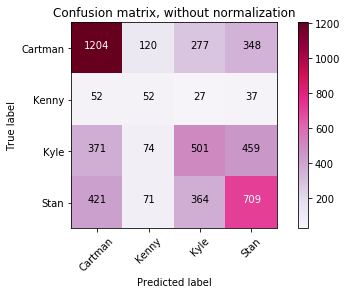

In [51]:
nb = MultinomialNB(fit_prior=False)
character_detector1 = nb.fit(X_train1, y_train1)
char_pred1 = character_detector1.predict(X_test1)
print(classification_report(y_test1, char_pred1))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test1, char_pred1), classes=character_detector1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuRd)
plt.show()

In [52]:
# Все метрики низкие. Лучше всего классифицируется Картмен, но даже у него много реплик приписаны другим 
# и ему приписаны много неправильных чужик реплик. Хуже всего классифицируется Кенни.

In [53]:
# Дерево решений

             precision    recall  f1-score   support

    Cartman       0.52      0.54      0.53      1949
      Kenny       0.22      0.15      0.18       168
       Kyle       0.39      0.38      0.39      1405
       Stan       0.41      0.41      0.41      1565

avg / total       0.44      0.44      0.44      5087

Confusion matrix, without normalization
[[1057   46  389  457]
 [  62   25   38   43]
 [ 440   22  535  408]
 [ 493   22  408  642]]


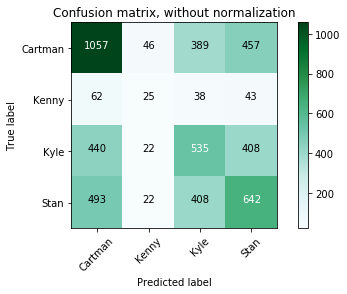

In [56]:
clf1 = DecisionTreeClassifier()
clf1.fit(X_train1, y_train1)
char_pred_clf1 = clf1.predict(X_test1)
print(classification_report(y_test1, char_pred_clf1))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test1, char_pred_clf1), classes=clf1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.BuGn)
plt.show()

In [35]:
# Метрики стали хуже. По прежнему лучше всего классифицируется Картмен. Хуже всего Кенни.

             precision    recall  f1-score   support

    Cartman       0.54      0.67      0.60      1949
      Kenny       0.34      0.12      0.18       168
       Kyle       0.43      0.34      0.38      1405
       Stan       0.44      0.41      0.43      1565

avg / total       0.47      0.48      0.47      5087

Confusion matrix, without normalization
[[1313   21  266  349]
 [  64   21   31   52]
 [ 495    9  479  422]
 [ 569   10  337  649]]


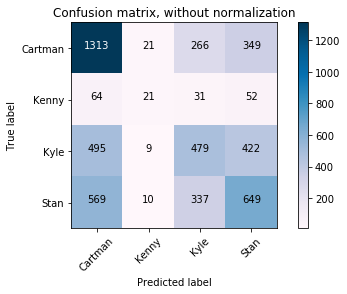

In [57]:
rf1 = RandomForestClassifier(n_estimators=50)
rf1.fit(X_train1, y_train1)
char_pred_rf1 = rf1.predict(X_test1)
print(classification_report(y_test1, char_pred_rf1))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test1, char_pred_rf1), classes=rf1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuBu)
plt.show()

In [37]:
# Метрики ниже чем у Байеса, но выше чем дерево решений. По прежнему лучше всего классифицируется Картмен. Хуже всего Кенни.

In [38]:
# Логистическая регрессия

             precision    recall  f1-score   support

    Cartman       0.64      0.60      0.62      1949
      Kenny       0.15      0.50      0.23       168
       Kyle       0.43      0.38      0.40      1405
       Stan       0.46      0.43      0.44      1565

avg / total       0.51      0.48      0.49      5087

Confusion matrix, without normalization
[[1163  174  290  322]
 [  22   84   30   32]
 [ 290  141  533  441]
 [ 355  154  389  667]]


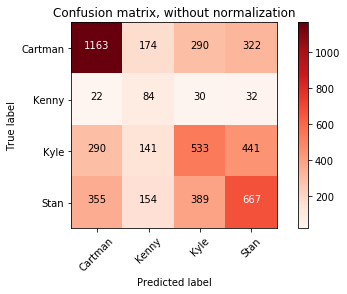

In [59]:
lr1 = LogisticRegression(class_weight='balanced')
lr1.fit(X_train1, y_train1)
char_pred_lr1 = lr1.predict(X_test1)
print(classification_report(y_test1, char_pred_lr1))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test1, char_pred_lr1), classes=lr1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Reds)
plt.show()

In [41]:
# У логистической регрессии метрики как у Наивного Байеса. Немного лучше классифицируется Кенни и Кайл, но Картмен и Стэн хуже.

In [43]:
print(lr1.coef_)

[[ 0.41961394 -0.32880009  0.47350041 ...,  0.27972858 -0.2309847
  -0.18540166]
 [-0.23244181 -0.10648104 -0.25839023 ..., -0.00277471 -0.03998795
  -0.22191949]
 [-0.21725893 -0.07412641 -0.96677731 ..., -0.22311785  0.51421999
  -0.22636921]
 [-0.22115222  0.58321396  0.36869971 ..., -0.07709571 -0.20565128
   0.48442605]]


In [44]:
# Тут сейчас так много фичей, что невозможно разобрать, у чего какой коэфиициент.

In [45]:
# TfidfVectorizer, Lemmatize

In [46]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_data['line'], new_data['character'],
                                                               test_size=0.2)

In [49]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize)
X_train2 = vectorizer.fit_transform(X_train2)
X_test2 = vectorizer.transform(X_test2)

In [50]:
# Наивный Байес

             precision    recall  f1-score   support

    Cartman       0.57      0.67      0.62      1928
      Kenny       0.24      0.15      0.19       181
       Kyle       0.46      0.32      0.38      1431
       Stan       0.45      0.51      0.48      1547

avg / total       0.49      0.50      0.49      5087

Confusion matrix, without normalization
[[1287   41  219  381]
 [  77   28   23   53]
 [ 438   22  454  517]
 [ 450   24  291  782]]


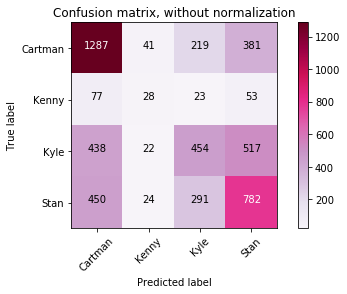

In [58]:
nb = MultinomialNB(fit_prior=False)
character_detector2 = nb.fit(X_train2, y_train2)
char_pred2 = character_detector2.predict(X_test2)
print(classification_report(y_test2, char_pred2))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, char_pred2), classes=character_detector2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuRd)
plt.show()

In [ ]:
# У этого наивного Байеса по сравнению с предыдущим особо ничего не поменялось. Хуже начал классифицироваться Кенни.

In [60]:
# Дерево решений

             precision    recall  f1-score   support

    Cartman       0.52      0.56      0.54      1928
      Kenny       0.26      0.17      0.21       181
       Kyle       0.39      0.37      0.38      1431
       Stan       0.41      0.41      0.41      1547

avg / total       0.44      0.45      0.44      5087

Confusion matrix, without normalization
[[1073   29  392  434]
 [  65   31   37   48]
 [ 430   28  531  442]
 [ 488   29  395  635]]


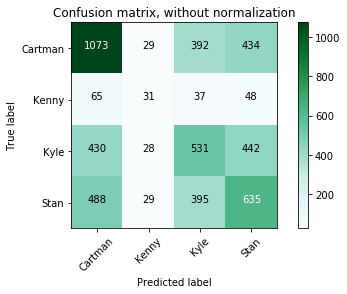

In [62]:
clf2 = DecisionTreeClassifier()
clf2.fit(X_train2, y_train2)
char_pred_clf2 = clf2.predict(X_test2)
print(classification_report(y_test2, char_pred_clf2))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, char_pred_clf2), classes=clf2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.BuGn)
plt.show()

In [ ]:
# По сравнению с тем деревом решений почти ничего не изменилось. На 1% стал лучше средний recall. Классифицируются все также.

In [63]:
# Лес решений

             precision    recall  f1-score   support

    Cartman       0.53      0.73      0.61      1928
      Kenny       0.43      0.16      0.23       181
       Kyle       0.46      0.31      0.37      1431
       Stan       0.46      0.40      0.43      1547

avg / total       0.48      0.49      0.48      5087

Confusion matrix, without normalization
[[1415   10  202  301]
 [  76   29   29   47]
 [ 584   15  444  388]
 [ 620   13  290  624]]


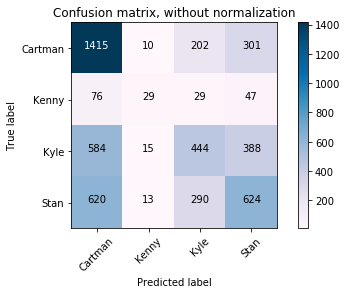

In [64]:
rf2 = RandomForestClassifier(n_estimators=50)
rf2.fit(X_train2, y_train2)
char_pred_rf2 = rf2.predict(X_test2)
print(classification_report(y_test2, char_pred_rf2))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, char_pred_rf2), classes=rf1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuBu)
plt.show()

In [65]:
# Этот лес по сравнению с прошлым работает чуть-чуть лучше - все иетрики чуть-чуть выше. Но не намного.

In [66]:
# Логистическая регрессия

             precision    recall  f1-score   support

    Cartman       0.59      0.64      0.62      1928
      Kenny       0.18      0.50      0.26       181
       Kyle       0.46      0.37      0.41      1431
       Stan       0.48      0.42      0.45      1547

avg / total       0.51      0.49      0.50      5087

Confusion matrix, without normalization
[[1241  124  256  307]
 [  46   90   26   19]
 [ 387  146  530  368]
 [ 420  148  332  647]]


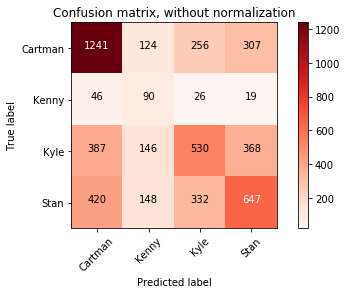

In [67]:
lr2 = LogisticRegression(class_weight='balanced')
lr2.fit(X_train2, y_train2)
char_pred_lr2 = lr2.predict(X_test2)
print(classification_report(y_test2, char_pred_lr2))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, char_pred_lr2), classes=lr2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Reds)
plt.show()

In [68]:
# Эта логистическая регрессия работает немного лучше той логистической регрессии - но не намного.

In [69]:
print(lr2.coef_)

[[ 0.03620325 -0.26448333  0.54215617 ...,  0.16542623 -0.16850791
  -0.20415491]
 [-0.00624413 -0.14089695 -0.4551389  ..., -0.02108554 -0.04900025
  -0.14211138]
 [-0.02998372 -0.16860839 -0.93624292 ..., -0.09487284  0.37667011
  -0.20029723]
 [-0.01687968  0.56676684  0.36038757 ..., -0.07749473 -0.13799435
   0.48113528]]


In [70]:
# Тут сейчас так много фичей, что невозможно разобрать, у чего какой коэфиициент.

In [71]:
# Фичи

In [75]:
# Все реплики Кенни в скобках.

In [77]:
new_data['line'] = new_data['line'].str.lower()

In [121]:
new_data['para'] = new_data['line'].map(lambda line: 1 if line.startswith('(') else 0)
new_data.groupby(['character']).agg({'para': 'mean'})

,para
character,
Cartman,0.000307
Kenny,0.956867
Kyle,0.001831
Stan,0.000651


In [79]:
new_data['fuck'] = new_data['line'].str.count('fuck')
new_data.groupby(['character']).agg({'fuck': 'mean'})

,fuck
character,
Cartman,0.030182
Kenny,0.094211
Kyle,0.010001
Stan,0.007292


In [80]:
new_data['guys'] = new_data['line'].str.count('guys')
new_data.groupby(['character']).agg({'guys': 'mean'})

,guys
character,
Cartman,0.088500
Kenny,0.046538
Kyle,0.024510
Stan,0.039844


In [81]:
new_data['respect'] = new_data['line'].str.count('respect')
new_data.groupby(['character']).agg({'respect': 'mean'})

,respect
character,
Cartman,0.001739
Kenny,0.000000
Kyle,0.000563
Stan,0.000260


In [82]:
new_data['kenny'] = new_data['line'].str.count('kenny')
new_data.groupby(['character']).agg({'kenny': 'mean'})

,kenny
character,
Cartman,0.039288
Kenny,0.004540
Kyle,0.026060
Stan,0.027474


In [84]:
new_data['screw'] = new_data['line'].str.count('screw')
new_data.groupby(['character']).agg({'screw': 'mean'})

,screw
character,
Cartman,0.009208
Kenny,0.004540
Kyle,0.004508
Stan,0.002865


In [85]:
new_data['bitch'] = new_data['line'].str.count('bitch')
new_data.groupby(['character']).agg({'bitch': 'mean'})

,bitch
character,
Cartman,0.017188
Kenny,0.003405
Kyle,0.003803
Stan,0.003646


In [86]:
new_data['length'] = new_data['line'].map(lambda text: len(text))

In [92]:
new_data['kill'] = new_data['line'].str.count('killed')
new_data.groupby(['character']).agg({'kill': 'mean'})

,kill
character,
Cartman,0.001739
Kenny,0.003405
Kyle,0.003803
Stan,0.008333


In [96]:
new_data['stan'] = new_data['line'].str.count('stan')
new_data.groupby(['character']).agg({'stan': 'mean'})

,stan
character,
Cartman,0.034275
Kenny,0.011351
Kyle,0.043809
Stan,0.014714


In [97]:
new_data['kyle'] = new_data['line'].str.count('kyle')
new_data.groupby(['character']).agg({'kyle': 'mean'})

,kyle
character,
Cartman,0.091058
Kenny,0.014756
Kyle,0.004085
Stan,0.039974


In [99]:
new_data['eric'] = new_data['line'].str.count('[eric, cartman]')
new_data.groupby(['character']).agg({'eric': 'mean'})

,eric
character,
Cartman,40.514733
Kenny,13.175936
Kyle,27.127905
Stan,26.876953


In [110]:
new_data['ass'] = new_data['line'].str.count('ass')
new_data.groupby(['character']).agg({'ass': 'mean'})

,ass
character,
Cartman,0.050952
Kenny,0.019296
Kyle,0.039301
Stan,0.028516


In [125]:
new_data['exl'] = new_data['line'].str.count('!')
new_data.groupby(['character']).agg({'exl': 'mean'})

,exl
character,
Cartman,0.871291
Kenny,0.615210
Kyle,0.558389
Stan,0.438672


In [129]:
new_data['mom'] = new_data['line'].str.count('mom')
new_data.groupby(['character']).agg({'mom': 'mean'})

,mom
character,
Cartman,0.040413
Kenny,0.009081
Kyle,0.014650
Stan,0.016536


In [133]:
new_data['dot'] = new_data['line'].str.count('.')
new_data.groupby(['character']).agg({'dot': 'mean'})

,dot
character,
Cartman,70.487927
Kenny,26.557321
Kyle,47.110015
Stan,46.891016


In [140]:
new_data['bastard'] = new_data['line'].str.count('bastard')
new_data.groupby(['character']).agg({'bastard': 'mean'})

,bastard
character,
Cartman,0.000512
Kenny,0.001135
Kyle,0.008029
Stan,0.000651


In [144]:
new_data['home'] = new_data['line'].str.count('home')
new_data.groupby(['character']).agg({'home': 'mean'})

,home
character,
Cartman,0.014324
Kenny,0.003405
Kyle,0.008311
Stan,0.009766


In [145]:
features = ['length', 'bitch', 'fuck', 'screw', 'kenny', 'guys', 'para', 'kill', 'kyle', 'eric', 'ass', 'exl', 'mom', 'dot',
           'bastard', 'home']

In [148]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(new_data[features], new_data['character'],
                                                               test_size=0.2)

             precision    recall  f1-score   support

    Cartman       0.58      0.18      0.27      1948
      Kenny       0.25      0.96      0.39       180
       Kyle       0.34      0.27      0.30      1454
       Stan       0.34      0.60      0.44      1505

avg / total       0.43      0.36      0.33      5087

Confusion matrix, without normalization
[[345 219 479 905]
 [  3 172   3   2]
 [ 93 153 397 811]
 [158 154 293 900]]


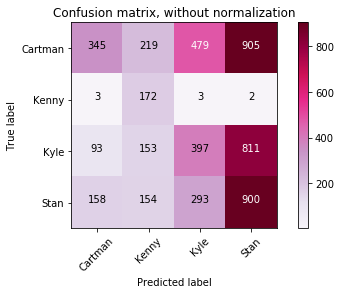

In [149]:
nb = MultinomialNB(fit_prior=False)
character_detector3 = nb.fit(X_train3, y_train3)
char_pred3 = character_detector3.predict(X_test3)
print(classification_report(y_test3, char_pred3))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test3, char_pred3), classes=character_detector3.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuRd)
plt.show()

In [150]:
# Эта байесовская модель хуже обеих предыдущих. Она очень много реплик приписывет Кайлу и Стэну, и очень мало Картмену.
# Но она правильно приписала почти все реплики Кенни ему. Но еще она свалила кучу чужих реплик ему.

In [151]:
# Дерево решений

             precision    recall  f1-score   support

    Cartman       0.46      0.49      0.47      1948
      Kenny       0.95      0.94      0.95       180
       Kyle       0.32      0.30      0.31      1454
       Stan       0.34      0.34      0.34      1505

avg / total       0.40      0.41      0.41      5087

Confusion matrix, without normalization
[[951   3 483 511]
 [  5 169   2   4]
 [538   3 434 479]
 [564   2 421 518]]


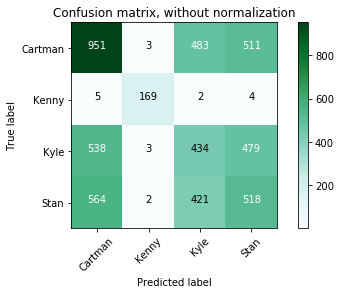

In [152]:
clf3 = DecisionTreeClassifier()
clf3.fit(X_train3, y_train3)
char_pred_clf3 = clf3.predict(X_test3)
print(classification_report(y_test3, char_pred_clf3))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test3, char_pred_clf3), classes=clf2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.BuGn)
plt.show()

In [153]:
# Дерево работает хуже чем оба предыдущих, но! очень хорошо определяются реплики Кенни. Классификатор пропустил всего лишь
# 9 реплик Кенни и приписал ему всего лишь 8 чужих реплик. Но все остальные определяются хуже.

In [154]:
# Лес решений

             precision    recall  f1-score   support

    Cartman       0.48      0.50      0.49      1948
      Kenny       0.96      0.95      0.95       180
       Kyle       0.33      0.28      0.31      1454
       Stan       0.35      0.39      0.37      1505

avg / total       0.42      0.42      0.42      5087

Confusion matrix, without normalization
[[974   3 437 534]
 [  4 171   2   3]
 [503   3 414 534]
 [529   2 392 582]]


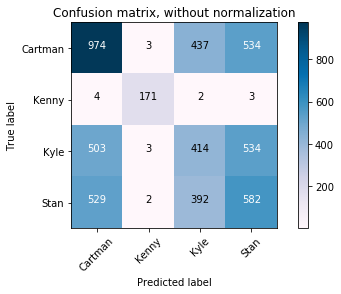

In [156]:
rf3 = RandomForestClassifier(n_estimators=50)
rf3.fit(X_train3, y_train3)
char_pred_rf3 = rf3.predict(X_test3)
print(classification_report(y_test3, char_pred_rf3))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test3, char_pred_rf3), classes=rf1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuBu)
plt.show()

In [157]:
# Лес работает хуже чем оба предыдущих, но! опять же очень хорошо определяются реплики Кенни. Классификатор пропустил всего лишь
# 9 реплик Кенни и приписал ему всего лишь 8 чужих реплик. Но все остальные определяются хуже.

In [158]:
# Логистическая регрессия

             precision    recall  f1-score   support

    Cartman       0.53      0.52      0.52      1948
      Kenny       0.97      0.96      0.96       180
       Kyle       0.37      0.19      0.25      1454
       Stan       0.37      0.55      0.44      1505

avg / total       0.45      0.45      0.44      5087

Confusion matrix, without normalization
[[1005    0  251  692]
 [   4  172    3    1]
 [ 433    4  281  736]
 [ 444    1  227  833]]


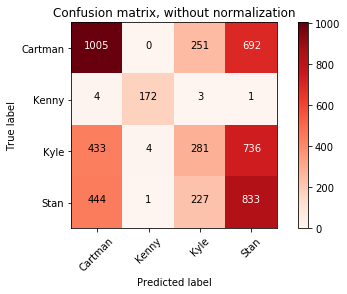

In [159]:
lr3 = LogisticRegression(class_weight='balanced')
lr3.fit(X_train3, y_train3)
char_pred_lr3 = lr3.predict(X_test3)
print(classification_report(y_test3, char_pred_lr3))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test3, char_pred_lr3), classes=lr2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Reds)
plt.show()

In [160]:
# Классификатор работает хуже чем оба предыдущих, но! опять же очень хорошо определяются реплики Кенни. 
# Классификатор пропустил всего лишь
# 8 реплик Кенни и приписал ему всего лишь 5 чужих реплик. Но все остальные определяются хуже.

In [175]:
char = ['Cartman', 'Kenny', 'Kyle', 'Stan']
for l in range(len(lr2.coef_)):
    print(char[l])
    for i in range(len(lr2.coef_[l])):
        try:
            print(features[i] + ' - ' + str(round(lr2.coef_[l][i], 3)))
        except:
            IndexError
    print('')

Cartman
length - 0.036
bitch - -0.264
fuck - 0.542
screw - 0.457
kenny - -0.228
guys - 0.032
para - 0.245
kill - -0.07
kyle - 0.37
eric - 0.063
ass - -0.239
exl - -0.165
mom - 0.178
dot - -0.133
bastard - -0.378
home - 0.134

Kenny
length - -0.006
bitch - -0.141
fuck - -0.455
screw - -0.69
kenny - -0.125
guys - -0.04
para - -0.086
kill - -0.299
kyle - -0.067
eric - -0.047
ass - -0.122
exl - -0.019
mom - -0.138
dot - -0.046
bastard - -0.151
home - -0.048

Kyle
length - -0.03
bitch - -0.169
fuck - -0.936
screw - -0.114
kenny - -0.041
guys - 0.081
para - -0.118
kill - 0.329
kyle - -0.223
eric - -0.035
ass - 0.062
exl - 0.237
mom - 0.424
dot - 0.296
bastard - 0.504
home - -0.075

Stan
length - -0.017
bitch - 0.567
fuck - 0.36
screw - -0.191
kenny - 0.345
guys - -0.08
para - -0.133
kill - -0.198
kyle - -0.174
eric - -0.041
ass - 0.277
exl - -0.05
mom - -0.535
dot - -0.106
bastard - 0.013
home - -0.061



In [176]:
# Для Картмена фича с самым большим коэффициентом - fuck(+).
# Для Кенни фича с самым большим коэффициентом - тоже fuck(-). Как ни странно у фичи наличия скобки в начале - 
# отрицательный коэффициент. Как и все другие коэффициенты.
# Для Кайла фича с самым большим коэффициентом - fuck(-). При чем коэффициент - 0.936. Но у Кайла самые низкие recall и precision.
# Для Стэна фича с самым большим коэффициентом - bitch(+).

In [177]:
# Значит, лучше всего работает вторая логистическая регрессия с TfidfVectorizer. И я только что заметила, что я удаляла пунктуацию 
# при токенизации. А ведь у Кенни везде скобки. Сейчас попробвем то же самое только без удаления.

In [178]:
tokenizer = RegexpTokenizer(r'\w+')
def lemmatize_w_punct(text):
    text = text.lower()
    words = word_tokenize(text)
    return [lmtzr.lemmatize(w) for w in words]

In [180]:
# Я нге сохранила тогда разделение на тест и трэйн, поэтому, к сожалению, этот результат будет на новом делении.

In [181]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_data['line'], new_data['character'],
                                                               test_size=0.2)

In [182]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize_w_punct)
X_train2 = vectorizer.fit_transform(X_train2)
X_test2 = vectorizer.transform(X_test2)

             precision    recall  f1-score   support

    Cartman       0.60      0.70      0.65      1967
      Kenny       0.94      0.95      0.94       170
       Kyle       0.45      0.40      0.42      1363
       Stan       0.49      0.44      0.46      1587

avg / total       0.54      0.55      0.54      5087

Confusion matrix, without normalization
[[1377    4  268  318]
 [   5  161    3    1]
 [ 409    6  545  403]
 [ 501    0  391  695]]


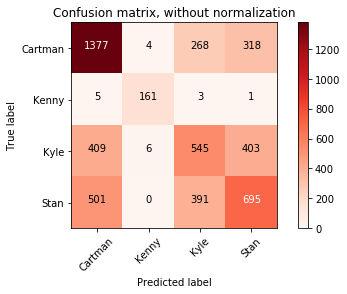

In [183]:
lr4 = LogisticRegression(class_weight='balanced')
lr4.fit(X_train2, y_train2)
char_pred_lr4 = lr4.predict(X_test2)
print(classification_report(y_test2, char_pred_lr4))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, char_pred_lr4), classes=lr2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Reds)
plt.show()

In [184]:
# Вот теперь это лучший результат. Очень хорошо классифицируется Кенни, неплохие показатели у Картмена. 
# И достаточно низкие у Кайла и Стэна.